# Neural Network (from scratch)

## Introduction
In this tutorial, we will implement a 2-layer neural network, based on components and techniques, we have seen so far. This notebook is based on the tutorial [nn from scratch](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/), which uses different activation functions and a softmax in the output layer.

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from scipy.special import expit

# Display plots inline
%matplotlib inline

## Dataset

Besides the datasets we have already worked with, [scikit-learn](http://scikit-learn.org/) provides some functions to generate toy data. Here, we will use [`make_circles`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), which generates two nested circles.

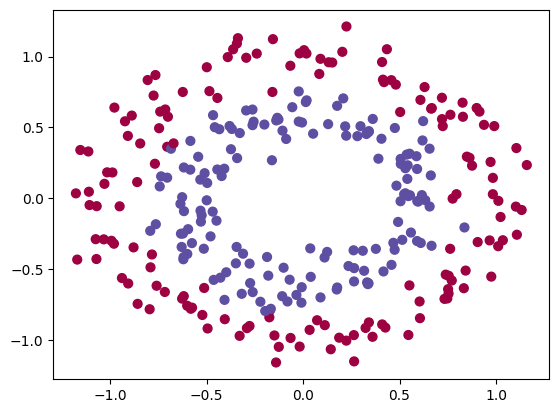

In [4]:
# Generate a dataset and plot it
np.random.seed(0)

X_train, y_train = sklearn.datasets.make_circles(300, factor=0.6,noise=0.10)
y_train = y_train.reshape((-1,1))

plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)
plt.show()

The dataset we generated has two classes, plotted as red and blue points. 

Our goal is to train a NN-classifier that predicts the correct class (red or blue - 0 or 1 respectively) given the x- and y- coordinates. Note that the data is not *linearly separable*, we can't draw a straight line that separates the two classes. This means that linear classifiers, such as Logistic Regression, won't be able to fit the data.

## Architecture

We are going to build a 2-layer neural network with one input layer, one hidden layer and one output layer. 

The number of nodes in the input layer is determined by the dimensionality of our data, which is 2. Since our classification problem is binary, a single neuron in the output is sufficient. In the hidden layer, we are free to choose the number of neurons. The more nodes in the hidden layer, the more complex functions we will be able to fit. On the other hand, increasing the number of nodes in the hidden layer, means increasing the computational effort and the model is more prone to overfitting the training data set. We will try different sizes of the hidden layer and see how it affects the output. 

We choose the logistic function as activation function in the hidden and output layers.

<img src="./pics/simple_NN.png"/>

### How the network makes predictions

The network makes predictions using *forward propagation*, transforming the vector of input features layer-by-layer. 

The transformation is performed by multiplying a feature vector with a weight matrix $W$, adding a bias term $b$ and applying an activation function. 

We start with a data matrix $X \in \mathbb{R}^{(N \times d)}$ consisting of $N$ data points with $d$ dimensions each. 
The vector of binary class labels is a column vector $\mathbf{y} \in \mathbb{R}^{(N, 1)}$.

This 2-layer neural network calculates the following function (forward pass):
$$
\begin{aligned}
Z^{[1]} & = X W^{[1]} + \mathbf{b}^{[1]} && \text{net input to hidden layer 1}\\
A^{[1]} & = \mathrm{sigmoid}(Z^{[1]}) && \text{activations in hidden layer 1} \\
\mathbf{z}^{[2]} & = A^{[1]} W^{[2]} + \mathbf{b}^{[2]} && \text{net input to output layer (hidden layer 2)} \\
\mathbf{a}^{[2]} & = \mathbf{\hat{y}} = \mathrm{sigmoid}(\mathbf{z}^{[2]}) && \text{activations in output layer (hidden layer 2)}
\end{aligned}
$$

The superscripts $[l]$ denote that the variable is associated with layer $l$. The function $\text{sigmoid}(\cdot)$ is the logistic function applied element-wise to each component (use `scipy.special.expit`). The individual components in $\mathbf{a}^{[2]}$ (or equivalently $\mathbf{\hat{y}}$) are interpreted as the predicted probabilities of any data point to belong to the class with label 1.

The parameters $\theta = \{W^{[1]}, \mathbf{b}^{[1]}, W^{[2]}, \mathbf{b}^{[2]} \}$ of the network are
$$
\begin{aligned}
W^{[1]} \in \mathbb{R}^{(d, k)} && \text{weight matrix in layer 1: d input features, k hidden neurons}\\
\mathbf{b}^{[1]} \in \mathbb{R}^{(1, k)} && \text{bias in layer 1: k hidden neurons}\\
W^{[2]} \in \mathbb{R}^{(k, 1)} && \text{weight matrix in layer 2: k hidden neurons, 1 output neuron}\\
\mathbf{b}^{[2]} \in \mathbb{R}^{(1, 1)} && \text{bias in layer 2: 1 output neuron}\\
\end{aligned}
$$

#### Binary cross-entropy loss
Since we are dealing with a binary classification problem, we use the Binary Cross Entropy (BCE) loss function to measure the error of the neural network. 

The loss for a single training example with label $y$ and predicted probabilty $\hat{y}$ is given as:
$$\mathcal{L}(\hat{y}, y) = - (y \log(\hat{y}) + (1-y) \log(1 - \hat{y}))$$ 

The total cost function is given as the mean of the loss over all data points $(i)$ in $X$:
$$J(\theta) = \frac{1}{N} \sum_{i=1}^N \mathcal{L}(\hat{y}^{(i)}, y^{(i)})$$

We _train_ the network by minimizing the cost function using gradient descent. 

#### Computation of derivatives

Similar to the _forward pass_, where we propagated the input forward through the network to the output layer, now we _propagate the error backwards_ to the parameters that led to this error.

To avoid recalculation of the same derivatives, the back-propagation algorithm calculates derivatives layer-by-layer starting from the last layer and propagates the derivatives backwards through the network. The algorithm calculates the following quantities at each layer $l$:
- The derivative of the error with respect to the net inputs $\frac{dJ}{dZ^{[l]}}$ (also called _delta_ values).
- The derivative of the error with respect to the parameters in layer $l$: $\frac{dJ}{dW^{[l]}}$ and $\frac{dJ}{d\mathbf{b}^{[l]}}$.
- The _delta_ values of the previous layer $\frac{dJ}{dZ^{[l-1]}}$


Concretely, we need to calculate the following quantities for this particular network:

$$
\begin{aligned}
\delta^{[2]} &= \frac{dJ}{d\mathbf{z}^{[2]}} = \mathbf{\hat{y}} - \mathbf{y} = \mathbf{a}^{[2]} - \mathbf{y} && ; \text{ shape: } (N, 1)\\
dW^{[2]} &= A^{{[1]}^T} \delta^{[2]}  && ; \text{ shape: } (k, 1)\\
db^{[2]} &= \sum_{i=1}^N \delta_i^{[2]}  && ; \text{ shape: } (1, 1) \text{ ; sum of rows in } \delta^{[2]}\\
\delta^{[1]} &= \delta^{[2]} W^{[2]^T} \cdot (A^{[1]} \cdot (\mathbb{1} - A^{[1]})) && ; \text{ shape: } (N, k) ; \mathbb{1} \text{ Unit matrix of all-ones}; \text{Dot } (\cdot) \text{ element-wise product}\\
dW^{[1]} &= X^T \delta^{[1]}  && ; \text{ shape: } (d, k)\\
db^{[1]} &= \sum_{i=1}^N \delta_i^{[1]}  && ; \text{ shape: } (1, k) ; \text{sum of rows in } \delta^{[1]}\\
\end{aligned}
$$

#### Gradient descent

To minimize $J(\theta)$, we update the parameters in the direction of the negative gradient:

$$
\begin{aligned}
W^{'[2]} &= W^{[2]} - \eta \cdot dW^{[2]}\\
b^{'[2]} &= b^{[2]} - \eta \cdot db^{[2]}\\
W^{'[1]} &= W^{[1]} - \eta \cdot dW^{[1]}\\
b^{'[1]} &= b^{[1]} - \eta \cdot db^{[1]}\\
\end{aligned}
$$

# Helper

#### Helper function to check if our gradient computation was correct

In [5]:
def numerical_gradient(func, w):
    """
    func: Is some function that takes w as parameter and evaluates to a scalar (e.g. the loss)
    w: Is the parameter vector passed to func
    return: Returns the gradient dw of func
    """
    n = len(w)
    dw = np.zeros_like(w)
    eps = 1e-6
    for i in range(n):
        w_tmp = np.copy(w)
        w_tmp[i] += eps
        f_0 = func(w)
        f_eps = func(w_tmp)
        dw[i] = (f_eps - f_0)/eps
    return dw

def numerical_gradient_check(func, w, dw, threshold=1e-4):
    num_dw = numerical_gradient(func, w)
    return np.all(np.abs(num_dw - dw) < threshold)

#### Example: How to check gradient computation

In [6]:
def myfunc(w):
    return w[0]**2.0 + w[1]**3.

def dmyfunc(w):
    dw = np.zeros_like(w)
    dw[0] = 2.0 * w[0]
    dw[1] = 3.0 * w[1]**2.0
    return dw

w = np.array([3., 2.])
num_dw = numerical_gradient(myfunc, w)
analytical_dw = dmyfunc(w)
print(num_dw, analytical_dw)

numerical_gradient_check(myfunc, w, analytical_dw)

[ 6.000001 12.000006] [ 6. 12.]


True

# Implementation

### Forward propagation

In [8]:
def forward_pass(X, params):
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    
    # Forward propagation
    
    # TODO
    
    z1 = 0.
    a1 = 0.
    z2 = 0.
    a2 = 0.
    p_class1 = a2
    
    activations = {'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2}
    
    return activations, p_class1

### Cost function (Binary cross-entropy)

In [7]:
def binary_cross_entropy(forward_func, X, y, params):
    
    # TODO
    
    bce = 0.
    return np.mean(bce)

### Compute gradient

In [9]:
def evaluate_gradient(cost_func, forward_func, X, y, params):
    # When calculating the sum for 'db', use numpy's sum with parameter 'keepdims'=True
    
    activations, predicted_prob = forward_func(X, params)
    
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    z1, a1, z2, a2 = activations['z1'], activations['a1'], activations['z2'], activations['a2']
    
    # TODO
    delta2 = 0.
    dW2 = 0.
    db2 = 0.
    delta1 = 0. 
    dW1 = 0.  
    db1 = 0.
    
    dparams = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    
    return dparams

### Gradient descent

In [10]:
def gradient_descent(params, dparams, eta=0.1):
    
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    dW1, db1, dW2, db2 = dparams['dW1'], dparams['db1'], dparams['dW2'], dparams['db2']
    
    # Gradient descent parameter update
    
    # TODO
    
    params = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    return params

### Training loop

In [11]:
nn_input_dim = 2       # input layer size
nn_hdim = 3            # hidden layer size
nn_output_dim = 1      # output layer size

def fit_model(X, y, n_hidden=3, num_epochs=2000, eta=0.1, print_loss=False):

    n_examples, n_inputs = X.shape
    _, n_outputs = y.shape
    
    W1 = np.random.randn(n_inputs, n_hidden) / np.sqrt(n_inputs)
    b1 = np.zeros((1, n_hidden))
    W2 = np.random.randn(n_hidden, n_outputs) / np.sqrt(n_hidden)
    b2 = np.zeros((1, n_outputs))

    params = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    for i in range(1, num_epochs):

        # TODO
        cost = 0.

        if print_loss and i % 100 == 0:
            print(f"Cost in epoch {i}: {cost}")
            
    return params


def predict(X, params):
    activations, p_class1 = forward_pass(X, params)    
    return np.where(p_class1 > 0.5, 1, 0)

In [13]:
params = fit_model(X_train, y_train, n_hidden=3, num_epochs=2000, eta=0.1, print_loss=True)

Cost in epoch 100: 0.6923263213602634
Cost in epoch 200: 0.6870701020812633
Cost in epoch 300: 0.6523229573855919
Cost in epoch 400: 0.5299895292106609
Cost in epoch 500: 0.3206980283641686
Cost in epoch 600: 0.25890363301944935
Cost in epoch 700: 0.228290212309175
Cost in epoch 800: 0.20722183558573695
Cost in epoch 900: 0.19096545765636408
Cost in epoch 1000: 0.17790218552547363
Cost in epoch 1100: 0.16726826152710336
Cost in epoch 1200: 0.15856551425924573
Cost in epoch 1300: 0.15555835883387237
Cost in epoch 1400: 0.14768737381482674
Cost in epoch 1500: 0.14186094015795908
Cost in epoch 1600: 0.14919238503715598
Cost in epoch 1700: 0.13826839980150354
Cost in epoch 1800: 0.13214664908289828
Cost in epoch 1900: 0.1279960960632092


# Evaluation

In [14]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(X, y, pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Evaluate the function on the entire grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

### Generate test dataset

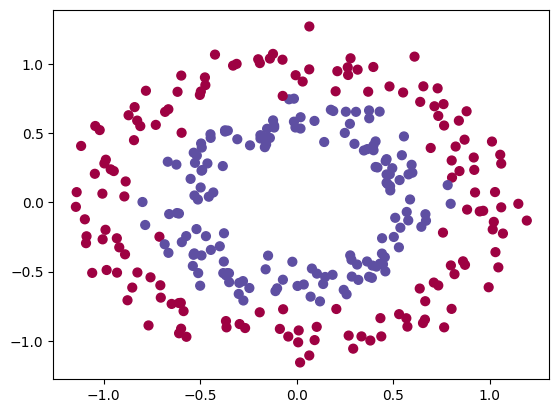

In [15]:
#X_test, y_test = sklearn.datasets.make_moons(200, noise=0.20)
X_test, y_test = sklearn.datasets.make_circles(300, factor=0.6, noise=0.10)
y_test = y_test.reshape((-1,1))

plt.scatter(X_test[:,0], X_test[:,1], s=40, c=y_test, cmap=plt.cm.Spectral)
plt.show()

#### Evaluate model for varying hidden layer sizes

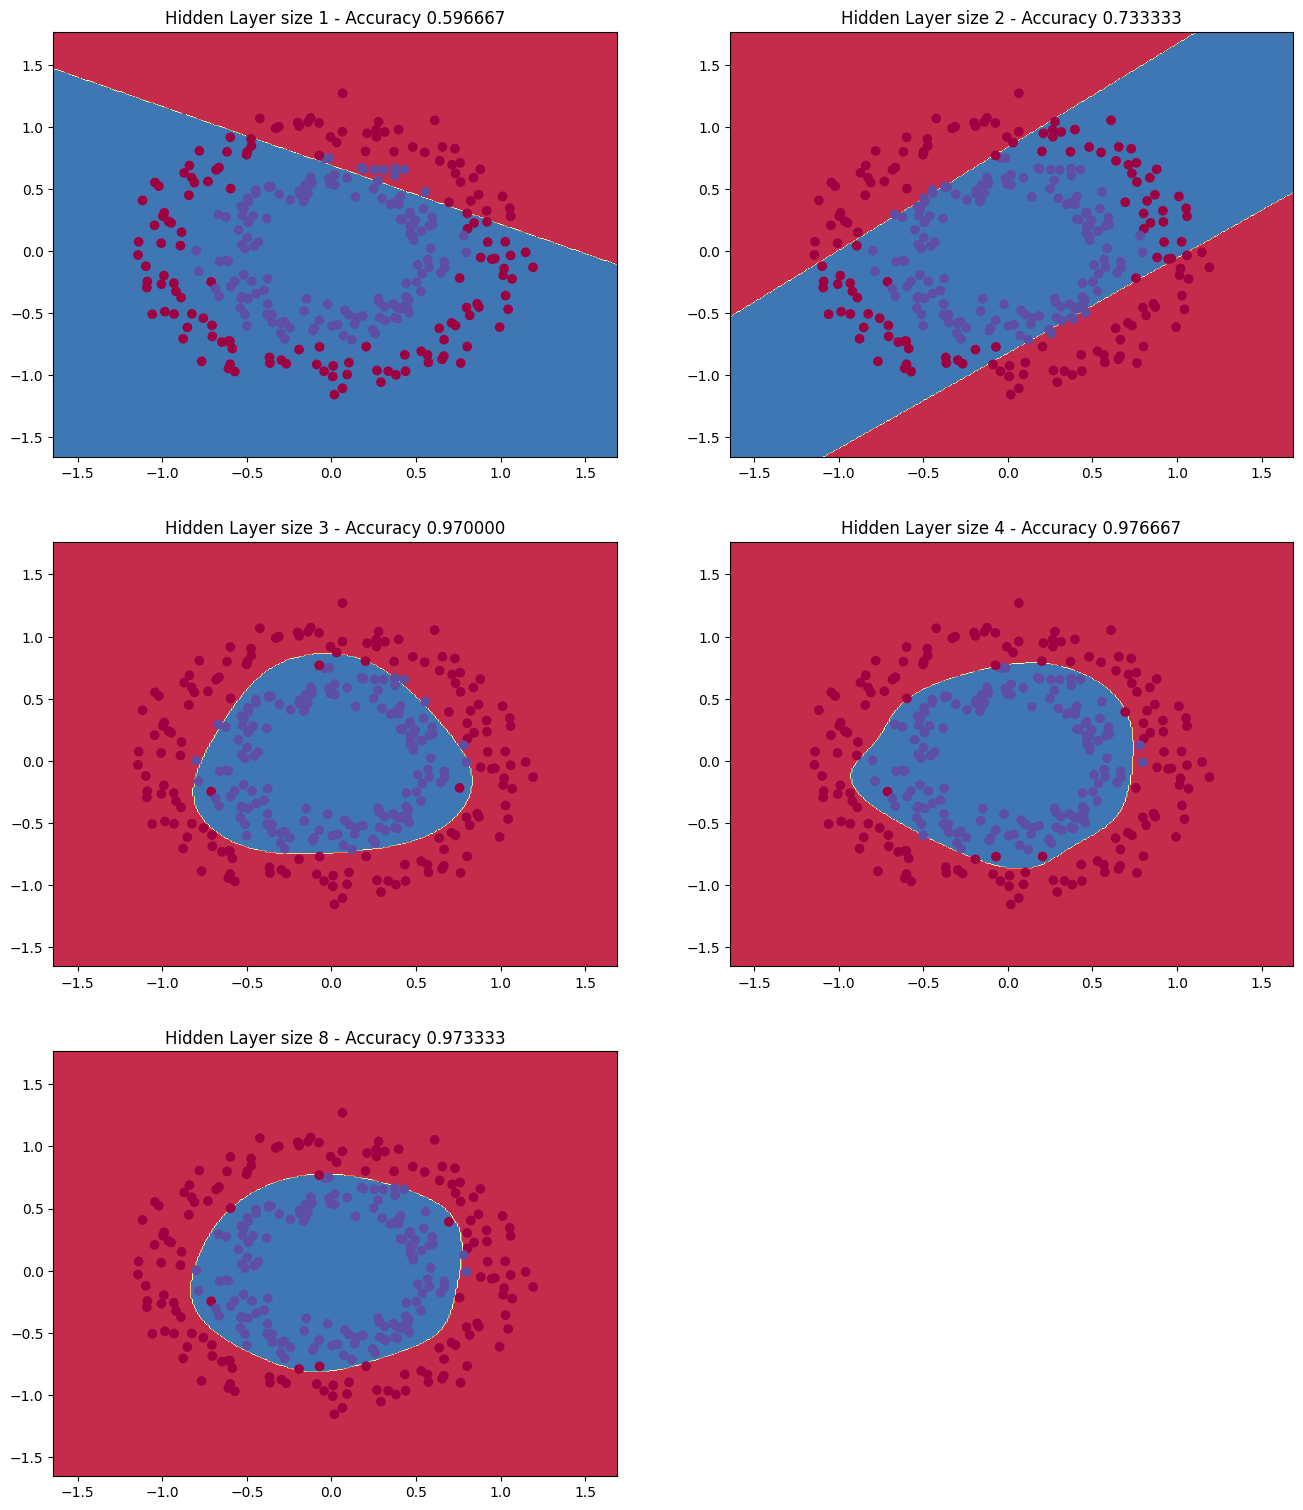

In [16]:
hidden_layer_sizes = [1, 2, 3, 4, 8]
n_examples = len(X_test)

plt.figure(figsize=(16, 32))

for i, n_hidden in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    
    params = fit_model(X_train, y_train, n_hidden=n_hidden, eta=0.1, num_epochs=2000)
    plot_decision_boundary(X_test, y_test, lambda x: predict(x, params))
    
    acc = np.mean(predict(X_test, params) == y_test)
    plt.title('Hidden Layer size %d - Accuracy %f' % (n_hidden, acc))
    
plt.show()

The models with only 1 or 2 neurons in the hidden layer are not able to fit a good classifier. But already with 3 neurons in the hidden layer, we can achieve a good separation of the classes. You may try different model parameters, maybe you can find a configuration that overfits. Nevertheless, following Occam's razor, the simpler models should be preferred. If you want to see a model that overfits, take a look at the source [tutorial](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/). There, tanh is used as activation function of the hidden layer instead of a sigmoid and a softmax in the output (instead of sigmoid).